<a href="https://colab.research.google.com/github/zii-bee/crispy-tsla-stock/blob/main/tsla_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
ticker = 'TSLA'

start_date = '2020-01-01'
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start_date, end=end_date)

df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
df = df[['Date', 'Close']]

In [4]:
df['Date'] # ensure Date is in datetime format

,Date
0,2020-01-02
1,2020-01-03
2,2020-01-06
3,2020-01-07
4,2020-01-08
...,...
1283,2025-02-10
1284,2025-02-11
1285,2025-02-12
1286,2025-02-13


In [5]:
df.index = df.pop('Date')
df

Price,Close
Ticker,TSLA
Date,
2020-01-02,28.684000
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334
...,...
2025-02-10,350.730011
2025-02-11,328.500000


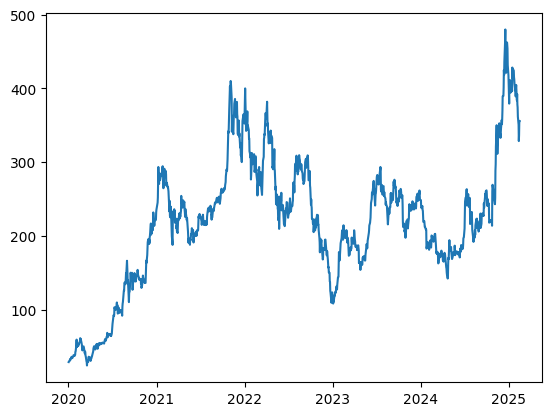

In [6]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

from sklearn.preprocessing import MinMaxScaler

# scale the 'Close' prices
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [7]:
# make dataframe windowed
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    return windowed_data.dropna()

windowed_df = window_data(df, n=3)
windowed_df = windowed_df.reset_index() # to bring index col back
windowed_df

,Date,Target-3,Target-2,Target-1,Target
0,2020-01-07,0.010098,0.011963,0.013211,0.015774
1,2020-01-08,0.011963,0.013211,0.015774,0.019150
2,2020-01-09,0.013211,0.015774,0.019150,0.017570
3,2020-01-10,0.015774,0.019150,0.017570,0.017103
4,2020-01-13,0.019150,0.017570,0.017103,0.023936
...,...,...,...,...,...
1280,2025-02-10,0.776887,0.768440,0.740576,0.716683
1281,2025-02-11,0.768440,0.740576,0.716683,0.667909
1282,2025-02-12,0.740576,0.716683,0.667909,0.685483
1283,2025-02-13,0.716683,0.667909,0.685483,0.728114


In [8]:
import numpy as np

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  y = df_as_np[:, -1]
  return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape


((1285,), (1285, 3, 1), (1285,))

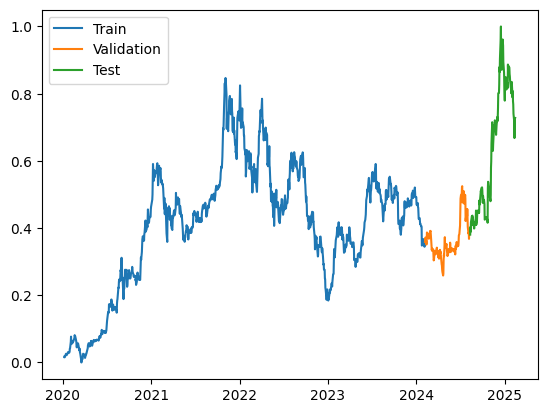

In [9]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

dates_train.shape, X_train.shape, y_train.shape

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
# loss_func is mean_squared_error
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1383 - mean_absolute_error: 0.3242 - val_loss: 0.0105 - val_mean_absolute_error: 0.0978
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mean_absolute_error: 0.0814 - val_loss: 0.0024 - val_mean_absolute_error: 0.0453
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0375 - val_loss: 4.2551e-04 - val_mean_absolute_error: 0.0147
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8609e-04 - mean_absolute_error: 0.0179 - val_loss: 4.4367e-04 - val_mean_absolute_error: 0.0151
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6925e-04 - mean_absolute_error: 0.0174 - val_loss: 4.6389e-04 - val_mean_absolute_error: 0.0157
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0287e-04 - mean_absolute_error: 0.0178 - val_loss: 4.2243e-04 - val_mean_absolute_error: 0.0147
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0463e-04 - mean_

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


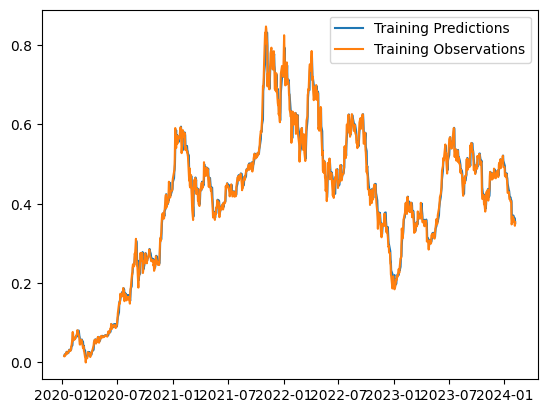

In [11]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


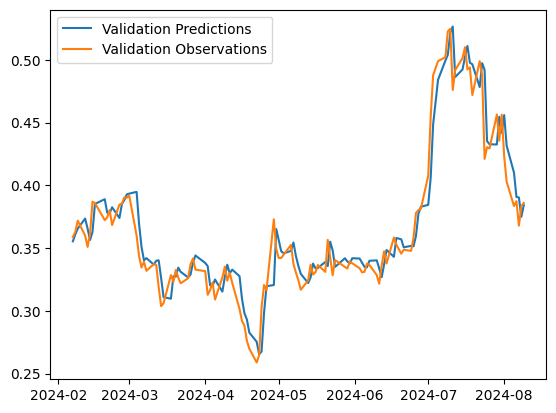

In [12]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


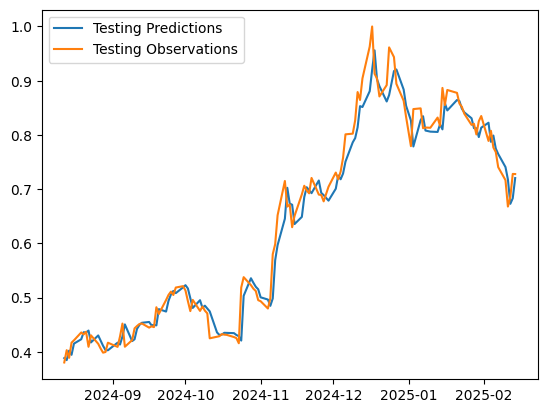

In [13]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

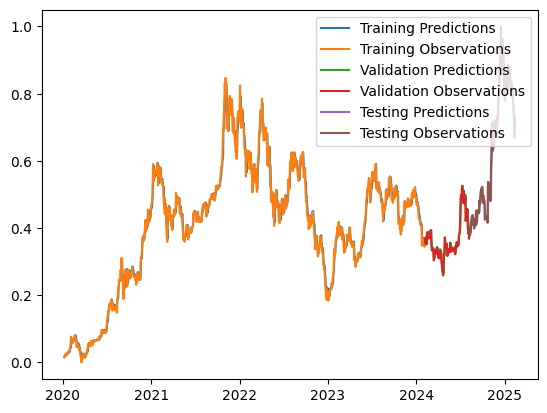

In [14]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [15]:
from copy import deepcopy
import numpy as np

recursive_predictions = []
# combine validation and test dates for recursive predictions
recursive_dates = np.concatenate([dates_val, dates_test])
# starting with last window
last_window_new = deepcopy(X_train[-1])

for target_date in recursive_dates:
    # next prediction based on current window
    next_prediction = model.predict(np.array([last_window_new])).flatten()[0]
    recursive_predictions.append(next_prediction)

    # if last_window_new = [a, b, c], then new window becomes [b, c, next_prediction].
    last_window_new[0] = last_window_new[1]
    last_window_new[1] = last_window_new[2]
    last_window_new[2] = next_prediction

recursive_predictions = np.array(recursive_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [16]:
# rescale back to realword prices
train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
val_predictions_rescaled = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
recursive_predictions_rescaled = scaler.inverse_transform(recursive_predictions.reshape(-1, 1)).flatten()

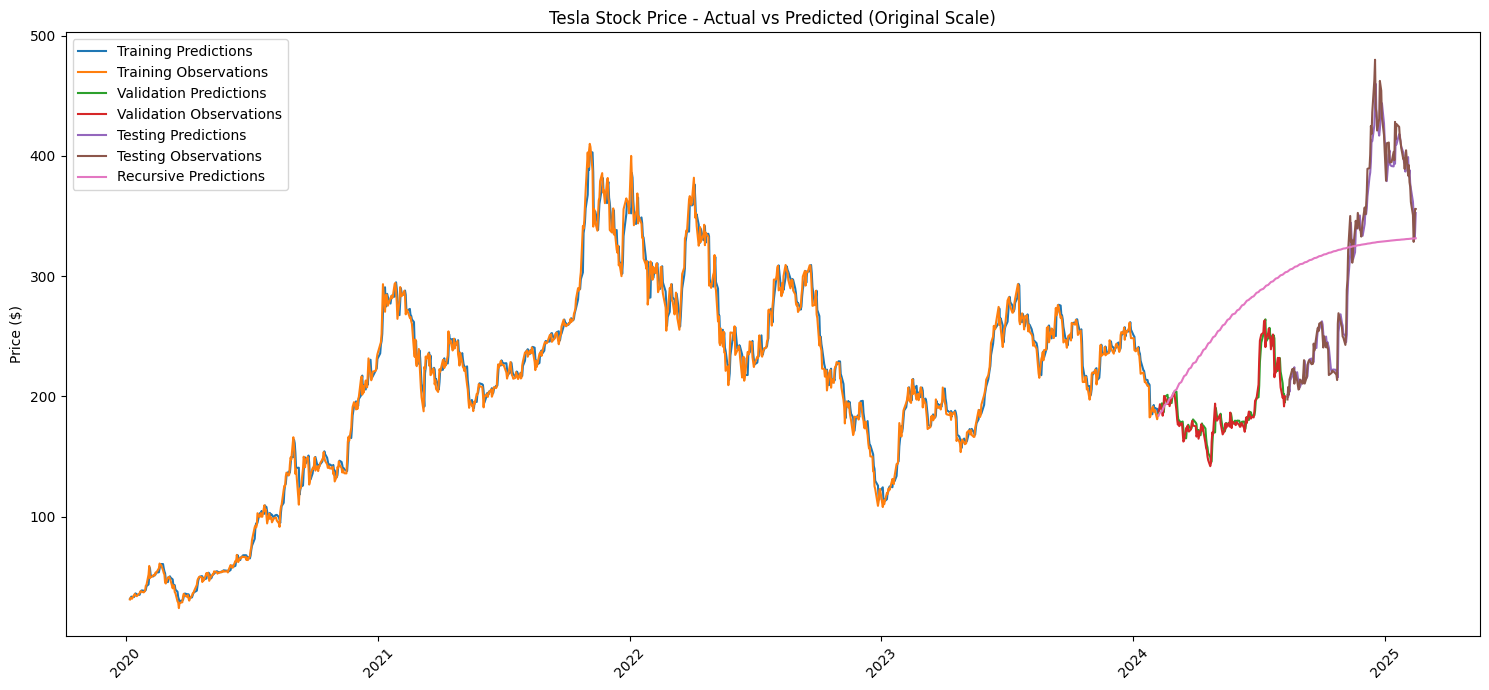

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(dates_train, train_predictions_rescaled)
plt.plot(dates_train, y_train_rescaled)
plt.plot(dates_val, val_predictions_rescaled)
plt.plot(dates_val, y_val_rescaled)
plt.plot(dates_test, test_predictions_rescaled)
plt.plot(dates_test, y_test_rescaled)
plt.plot(recursive_dates, recursive_predictions_rescaled)
plt.legend(['Training Predictions',
           'Training Observations',
           'Validation Predictions',
           'Validation Observations',
           'Testing Predictions',
           'Testing Observations',
            'Recursive Predictions'])
plt.title('Tesla Stock Price - Actual vs Predicted (Original Scale)')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed


Next Day Prediction Analysis:
Predicted price for next trading day: $354.94
Current price: $355.84
Predicted change: $-0.90 (-0.25%)

Model Performance Metrics:
Mean Absolute Error: $9.77
Root Mean Square Error: $13.50
Mean Absolute Percentage Error: 3.06%

Prediction Interval (95% confidence):
Lower bound: $329.06
Upper bound: $380.82



<ipython-input-18-8d40e1e40dd3>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(original_df['Close'].iloc[-1])


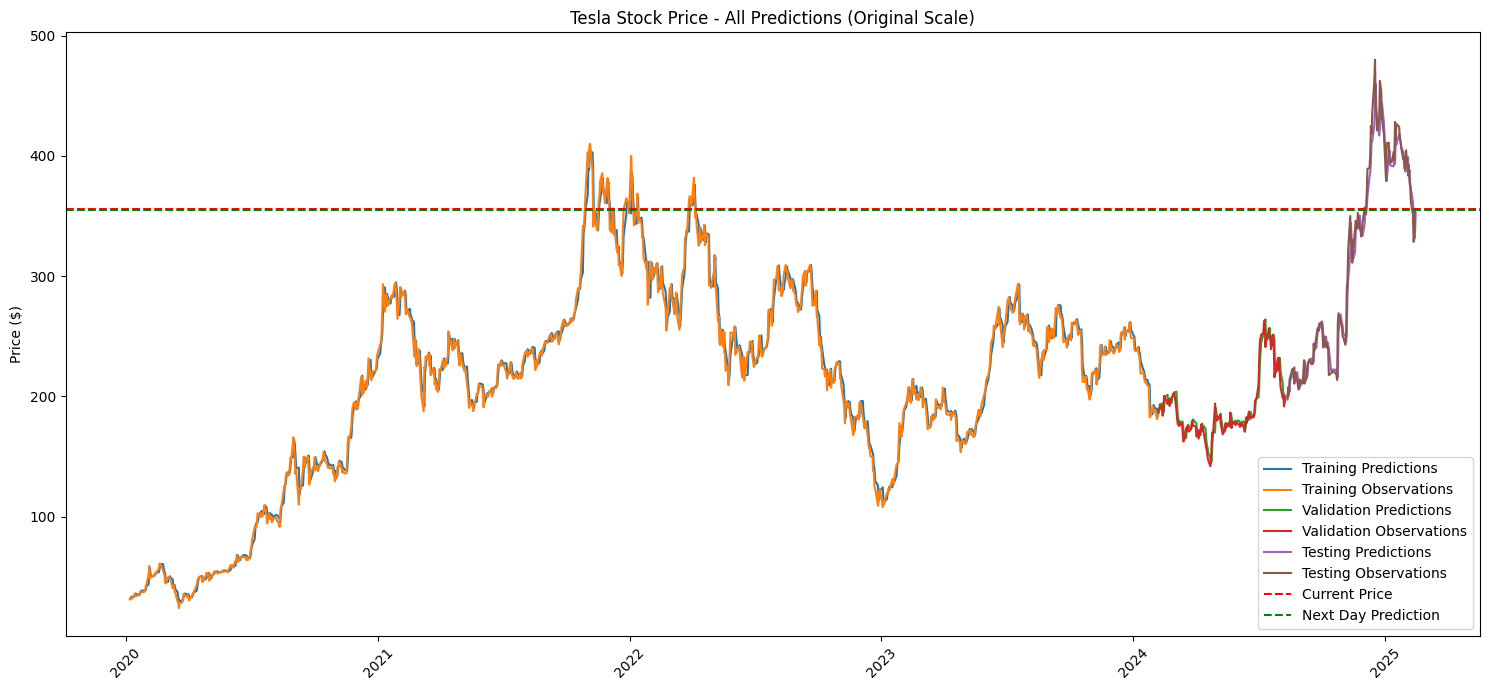

In [18]:
def predict_next_day(model, last_known_prices, scaler):
    last_window = last_known_prices[-3:].reshape(1, 3, 1)

    next_day_scaled = model.predict(last_window).flatten()[0]
    next_day_price = scaler.inverse_transform([[next_day_scaled]])[0][0]

    return next_day_price

recent_prices = df['Close'].values[-3:]
next_day_price = predict_next_day(model, recent_prices, scaler)

test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse = np.mean((test_predictions_rescaled - y_test_rescaled) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predictions_rescaled - y_test_rescaled))
mape = np.mean(np.abs((test_predictions_rescaled - y_test_rescaled) / y_test_rescaled)) * 100

original_df = yf.download(ticker, start=start_date, end=end_date)
current_price = float(original_df['Close'].iloc[-1])

print("\nNext Day Prediction Analysis:")
print(f"Predicted price for next trading day: ${next_day_price:.2f}")
print(f"Current price: ${current_price:.2f}")
print(f"Predicted change: ${(next_day_price - current_price):.2f} ({((next_day_price - current_price)/current_price * 100):.2f}%)")
print(f"\nModel Performance Metrics:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Square Error: ${rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

confidence_level = 0.95
std_dev = np.std(test_predictions_rescaled - y_test_rescaled)
margin_of_error = std_dev * 1.96  # 95% confidence interval

print(f"\nPrediction Interval (95% confidence):")
print(f"Lower bound: ${next_day_price - margin_of_error:.2f}")
print(f"Upper bound: ${next_day_price + margin_of_error:.2f}")

plt.figure(figsize=(15, 7))
plt.plot(dates_train, train_predictions_rescaled)
plt.plot(dates_train, y_train_rescaled)
plt.plot(dates_val, val_predictions_rescaled)
plt.plot(dates_val, y_val_rescaled)
plt.plot(dates_test, test_predictions_rescaled)
plt.plot(dates_test, y_test_rescaled)
plt.axhline(y=current_price, color='r', linestyle='--', label='Current Price')
plt.axhline(y=next_day_price, color='g', linestyle='--', label='Next Day Prediction')
plt.legend(['Training Predictions',
           'Training Observations',
           'Validation Predictions',
           'Validation Observations',
           'Testing Predictions',
           'Testing Observations',
           'Current Price',
           'Next Day Prediction'])
plt.title('Tesla Stock Price - All Predictions (Original Scale)')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()